In [ ]:
# Mean field like kernel

In [1]:


import numpy as np
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pymp
num_thread = 1

from numba import jit
from timeit import default_timer as timer


In [2]:
file_dir = "fix_mu_T"

In [3]:
f = open('LJ_data_'+file_dir+'/MC_parameter.dat', 'r')
temp = f.read().split("\t")
L=float(temp[0])
dx=float(temp[1])
N=int(L/dx)
batch_size = int(temp[2])
f.close()
temp 

['32', '0.125', '64\n']

In [4]:
print(str(dx)+"\t"+str(L)+"\t"+str(batch_size))

0.125	32.0	64


In [5]:
mini_batch = 16

In [6]:
f = open('LJ_data_'+file_dir+'/MC_inform.dat', 'r')
MC_inform = f.read().splitlines()
for i in range(len(MC_inform)):
    #print(MC_inform[i])
    MC_inform[i]=MC_inform[i].split("\t")
f.close()
batch_size = (len(MC_inform)//mini_batch)*mini_batch

In [7]:
print(str(dx)+"\t"+str(N)+"\t"+str(L)+"\t"+str(batch_size))

0.125	256	32.0	64


In [8]:
MC_inform = np.array(MC_inform)
MC_inform = MC_inform.astype(float)

In [9]:
Nw = 1
Lw = int(np.floor(8/dx)+1)
LLw = int(np.floor(8/dx)/2)
rho_array = np.zeros((mini_batch,N))
rho0_array = np.zeros((mini_batch))
epsilon_array = np.zeros((mini_batch))
mu_array = np.zeros((mini_batch))
Vext_array = np.zeros((mini_batch,N))
Lw*dx

8.125

In [10]:
"""initial w"""
def initial_kernel():
    
    np.random.seed(0)
    w = np.random.normal(0,1,Nw*Lw)*0.01
    w=w.reshape((Nw,Lw))
    
    np.random.seed(1)
    return w

In [11]:
w = initial_kernel()

In [12]:
"""load data with shuffle"""
def load_data (batch_number):
    for j in range(mini_batch):
        i = batch_number[j]
        
        rho_array[j]=np.loadtxt("LJ_data_"+file_dir+"/rho_"+str(i)+".dat")
        #rho_array[j]=(rho_array[j]+rho_array[j][::-1])/2 #force symmetry ? 
        
        Vext_array[j]=np.loadtxt("LJ_data_"+file_dir+"/Vext_"+str(i)+".dat")
        epsilon_array[j]=float(MC_inform[i][1])
        mu_array[j]=np.log(float(MC_inform[i][2]))
        
    return rho_array,Vext_array,epsilon_array,mu_array

In [13]:
@jit
def conv (rho,w):

    rho_pad=np.pad(rho,(LLw,LLw),'symmetric')
    rho_pad[0:LLw]=rho_pad[N:N+LLw]
    rho_pad[N+LLw:N+LLw*2]=rho_pad[LLw:LLw+LLw]
    n = np.correlate(rho_pad,w)
    
    return n*dx

In [14]:
@jit
def w_FMT(eps):
    R = 1.0/2
    k=np.linspace(0,N//2,N//2+1)*2*np.pi/L
    w0=2*np.cos(k*R)/2
    k[0]=1 #keep notebook shutup
    w1=2*np.sin(k*R)/k
    w1[0]=2*R
    return w0,w1;

@jit
def cal_n0(rho,w0):
    return np.fft.irfft(np.fft.rfft(rho)*w0)

@jit
def cal_n1(rho,w1):
    return np.fft.irfft(np.fft.rfft(rho)*w1)

@jit
def cal_c1_FMT(rho,eps):
    w0,w1 = w_FMT(eps)
    n0=cal_n0(rho,w0)
    n1=cal_n1(rho,w1)
    F0=-np.log(1-n1)
    F1=n0/(1-n1)
    return cal_n0(F0,w0)+cal_n1(F1,w1)
    
    

In [15]:
"""add FMT terms"""
@jit
def cal_c1(eps,n,w,rho):
    c1 = np.zeros((N))
    for i in range(Nw):
        c1+=2*eps*(n[i])
    c1+=cal_c1_FMT(rho,eps)
    return c1

In [16]:
@jit
def f2 (c1,x,mu,eps):
    rho_temp = np.full(N,x)
    c1_FMT = cal_c1_FMT(rho_temp,eps)[0]
    return (c1*x+np.log(x)+c1_FMT-mu)**2

@jit
def cal_rho0(mu,w,eps):
    
    c1=0  
    for i in range(Nw):
        c1+=eps*(np.sum(w[i]))*dx*2

    rho_guess = np.zeros(3)
    res = np.zeros(3)
    interval = 0.01

    for i in range(3):
        rho_guess[i] = 0.3+interval*i
        
    for iteration in range (10000):
        for i in range(3):
            res[i] = f2(c1,rho_guess[i],mu,eps)
        if(res[0]>res[1] and res[2]>res[1]):
            interval/=2
            rho_guess[0]=rho_guess[1]-interval
            rho_guess[2]=rho_guess[1]+interval
        elif(res[1]>res[0] and res[2]>res[0]):
            temp = rho_guess[0]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
        else:
            temp = rho_guess[2]
            rho_guess[0]=temp-interval
            rho_guess[1]=temp
            rho_guess[2]=temp+interval
            
        if(rho_guess[0]<0 or rho_guess[2]>1):
            break
        if(interval<10**-8):
            #print(rho_guess[1],iteration)
            break        
    
    temp=rho_guess[1]
    if(temp<=0):
        return 0.1
    elif(temp>1):
        return 0.9
    else:
        return rho_guess[1]

In [22]:
@jit
def f (rho,c,rhoML):
    return np.sum((rho-c*rhoML)**2)

@jit
def cal_mu_ML(rho,c1,Vext,Print=False):
    rhoML = np.exp(-c1-Vext)
    mu = np.log(np.sum(rho*rhoML)/np.sum(rhoML**2))
    if(Print):
        print(np.exp(mu))
    return mu
'''
    mu_guess = np.zeros(3)
    res = np.zeros(3)
    
    for i in range(3):
        mu_guess[i] = i-1.0
    interval = 1
    
    for iteration in range (1000):
        for i in range(3):
            res[i] = f(rho,mu_guess[i],rhoML)
        if(res[0]>res[1] and res[2]>res[1]):
            interval/=2
            mu_guess[0]=mu_guess[1]-interval
            mu_guess[2]=mu_guess[1]+interval
        elif(res[1]>res[0] and res[2]>res[0]):
            temp = mu_guess[0]
            mu_guess[0]=temp-interval
            mu_guess[1]=temp
            mu_guess[2]=temp+interval
        else:
            temp = mu_guess[2]
            mu_guess[0]=temp-interval
            mu_guess[1]=temp
            mu_guess[2]=temp+interval
        if(interval<10**-8):
            break
    #print(np.log(mu_guess[1]),mu_guess[1])
    return np.log(mu_guess[1])
'''
print()
     

In [23]:
@jit
def cal_rho_ML(mu,c1,V):
    rho_ML = np.exp(-c1-V+mu)
    return rho_ML

In [24]:
@jit
def error (rho,rho_ML):
    return np.sum((rho-rho_ML)**2)*dx


In [25]:
@jit
def DwF(rho,p,j):
    temp=np.zeros((N))
    temp+=2*np.roll(rho,-(p-LLw))*dx
    return temp

In [26]:
@jit
def Dwmu(rho0,w,j):
    c1=0
    c1+=2*(np.sum(rho0))*dx
    return c1

In [27]:
@jit
def Dw_tot(rho_ML,rho,rho0,j,p,eps,w):
    temp=np.zeros(mini_batch)
    for k in range(mini_batch): 
        temp[k]=np.sum((rho_ML[k]-rho[k])*(2)*rho_ML[k]*eps[k]*(
            2*rho0[k]-2*np.roll(rho[k],-(p-LLw))))
    #print(temp[k])
    return np.sum(temp)*dx**2

In [28]:

def ML_kernel(seed,w,alpha):
    np.random.seed(seed)
    batch_number=np.arange(batch_size)
    np.random.shuffle(batch_number)
    
    dw = np.zeros((w.shape), dtype='float')
    
    rhoML_array = np.zeros((mini_batch,N), dtype='float')
    rho0ML_array = np.zeros((mini_batch), dtype='float')
    n_array = np.zeros((mini_batch,Nw,N), dtype='float')
    
    epco_error = 0
    N_minbatch = int(batch_size/mini_batch)
    #print("AAA")
    for M in range(int(batch_size/mini_batch)):
        #print(str(M)+'/'+str(batch_size/mini_batch))
        rho_array,Vext_array,epsilon_array,mu_array=load_data (
            batch_number[M*mini_batch:(M+1)*mini_batch])
        
        for MM in range(mini_batch):
            for j in range (Nw):
                n_array[MM][j] = conv(rho_array[MM],w[j])

        for MM in range(mini_batch):
            c1 = cal_c1(epsilon_array[MM],n_array[MM],w,
                        rho_array[MM])
            mu_ML=cal_mu_ML(rho_array[MM],c1,Vext_array[MM])
            
            rho0ML_array[MM]=cal_rho0(mu_ML,w,epsilon_array[MM])
            rhoML_array[MM] = cal_rho_ML(mu_ML,c1,Vext_array[MM])

        epco_error+=error(rho_array,rhoML_array)

        for j in range(Nw):
            for p in range(Lw):
                dw[j][p]=Dw_tot(rhoML_array,rho_array,rho0ML_array,j,p,epsilon_array,w)
        
        w-=alpha*dw
        w*=(1-10**(-14))
    return w,epco_error

In [29]:
def save_data(w,error_array):
    
    """save kernel results"""
    np.savetxt(r"./ML_data/epco_error_mean.txt",error_array)
    np.savetxt(r"./ML_data/w_kernel_mean.txt",w)
    
    f = open('./ML_data/parameter_kernel_mean.txt', 'w')
    f.write(str(dx))
    f.write("\n")
    f.write(str(Lw))
    f.write("\n")
    f.write(str(Nw))
    f.write("\n")
    f.close()
    """save done"""

In [30]:
np.random.seed(1234565)
w = np.zeros(Nw*Lw)
w=initial_kernel()

w0=np.copy(w)

error_array=np.empty(0)
alpha = 0.1
start_time = timer()
"""initial by lower kernel"""
#w = np.loadtxt("./data/w_kernel.txt")
""""""
for i in range(1000000):

    w0=np.copy(w)
    w,epco_error=ML_kernel(i,w,alpha)
    error_array=np.append(error_array, epco_error)
    
    if(alpha<10**-6 or np.isnan(epco_error)):
        break
        
    if((epco_error>error_array[i-1] or np.isinf(epco_error))and i>0):
        alpha/=2.0
        #w=np.copy(w0)
        #beta=np.copy(beta0)
        print("alpha=",alpha)

    print(i,epco_error,alpha)
    save_data(w,error_array)
    #alpha/=10
end_time = timer()
print("elapse="+'\t'+str(end_time-start_time))
save_data(w,error_array)


0 0.8412938230141436 0.1
1 0.5197373111687382 0.1
2 0.37007730113112625 0.1
3 0.29261293187937343 0.1
4 0.24728679659067718 0.1
5 0.21714745926446677 0.1
6 0.1947238271668546 0.1
7 0.17665669787302818 0.1
8 0.16133603880262234 0.1
9 0.14793941573744912 0.1
10 0.1360291534763188 0.1
11 0.1253459300574671 0.1
12 0.11571631204614707 0.1
13 0.10701163491368636 0.1
14 0.09912732502963735 0.1
15 0.09197503644631855 0.1
16 0.08548067077572916 0.1
17 0.0795770825336301 0.1
18 0.0742038263692166 0.1
19 0.06930848331969633 0.1
20 0.0648459299030596 0.1
21 0.06076724794517041 0.1
22 0.05704162955258861 0.1
23 0.05363139450809934 0.1
24 0.05050490465806874 0.1
25 0.047636968269397284 0.1
26 0.0450021001345967 0.1
27 0.04257546734977588 0.1
28 0.04033990271563809 0.1
29 0.03827817353765231 0.1
30 0.036370715850458694 0.1
31 0.03460605867107294 0.1
32 0.032969029451312505 0.1
33 0.03144932118795293 0.1
34 0.030036081514814357 0.1
35 0.028719730624131194 0.1
36 0.027491744405335385 0.1
37 0.026344233

284 0.0010946886808722073 0.1
285 0.0010902969548942877 0.1
286 0.0010859558898639677 0.1
287 0.001081641165712833 0.1
288 0.0010773643382101846 0.1
289 0.0010731013287258182 0.1
290 0.0010689077092147121 0.1
291 0.0010646822986204335 0.1
292 0.0010605265272451106 0.1
293 0.0010564126461084617 0.1
294 0.0010523309251553661 0.1
295 0.001048280065956555 0.1
296 0.00104424548908421 0.1
297 0.001040288649934664 0.1
298 0.0010362976685681338 0.1
299 0.00103235997701489 0.1
300 0.0010285141357461748 0.1
301 0.0010245951186697677 0.1
302 0.0010207507469167474 0.1
303 0.0010169220050972533 0.1
304 0.0010131524819167678 0.1
305 0.001009406281458564 0.1
306 0.0010057334561788742 0.1
307 0.0010019589589057307 0.1
308 0.0009982950303187082 0.1
309 0.0009946488250249352 0.1
310 0.000991007162325061 0.1
311 0.000987425217256698 0.1
312 0.0009838452232181364 0.1
313 0.0009803163571365245 0.1
314 0.0009767970973463924 0.1
315 0.0009732820081479398 0.1
316 0.0009698424146247816 0.1
317 0.00096644335585

559 0.0005390470321386161 0.1
560 0.0005382187179045629 0.1
561 0.0005373614652795704 0.1
562 0.0005365376159862774 0.1
563 0.0005357382533048387 0.1
564 0.0005348778276045342 0.1
565 0.000534046058612257 0.1
566 0.0005332183084450725 0.1
567 0.0005324290655448436 0.1
568 0.0005315906571824568 0.1
569 0.0005307879068710404 0.1
570 0.0005299787413611463 0.1
571 0.0005291693967795046 0.1
572 0.0005283708936537967 0.1
573 0.0005276007436286523 0.1
574 0.0005268171037289513 0.1
575 0.0005260064320757814 0.1
576 0.0005252150280101716 0.1
577 0.0005244405660786034 0.1
578 0.0005236780979797651 0.1
579 0.0005229008236049875 0.1
580 0.0005221360962877204 0.1
581 0.0005213706039363788 0.1
582 0.0005205995973990169 0.1
583 0.0005198502032543935 0.1
584 0.0005191152436646558 0.1
585 0.0005183667421519894 0.1
586 0.0005175836090404929 0.1
587 0.0005168373895507889 0.1
588 0.0005161088797649607 0.1
589 0.0005153753971296894 0.1
590 0.0005146291846088367 0.1
591 0.0005139256337552006 0.1
592 0.00051

830 0.00040408328904351987 0.1
831 0.00040381975314054806 0.1
832 0.0004035491031142088 0.1
833 0.0004032488367975249 0.1
834 0.00040296454157993136 0.1
835 0.00040269765841820324 0.1
836 0.00040242647344117634 0.1
837 0.00040216324423451605 0.1
838 0.0004018585136032282 0.1
839 0.0004016018819400503 0.1
840 0.00040135449158789185 0.1
841 0.0004010818890178698 0.1
842 0.00040077543844641863 0.1
843 0.00040051782151231594 0.1
844 0.00040024280864474116 0.1
845 0.00039996257132276694 0.1
846 0.00039968806174057303 0.1
847 0.0003994282683605854 0.1
848 0.00039923018593851213 0.1
849 0.00039889378082122733 0.1
850 0.0003986435334359086 0.1
851 0.0003983944033333198 0.1
852 0.0003981158412228786 0.1
853 0.0003978779735565772 0.1
854 0.00039758148082440334 0.1
855 0.0003973290976950974 0.1
856 0.0003970724961424314 0.1
857 0.00039680008481974134 0.1
858 0.0003965497505945768 0.1
859 0.0003962979470141916 0.1
860 0.00039606646566978706 0.1
861 0.00039578900697079803 0.1
862 0.0003955704090684

1096 0.0003529237889206735 0.1
1097 0.0003528041873264871 0.1
1098 0.000352702271123767 0.1
1099 0.0003525756137919538 0.1
1100 0.00035241180246162277 0.1
1101 0.00035227702395528065 0.1
1102 0.00035217699497694746 0.1
1103 0.0003520243356920763 0.1
1104 0.0003519182911651457 0.1
1105 0.00035179493796264234 0.1
1106 0.00035167320888169134 0.1
1107 0.00035151039129053776 0.1
1108 0.00035139166899236346 0.1
1109 0.0003512551676606283 0.1
1110 0.0003511311223396966 0.1
1111 0.00035102646029520185 0.1
1112 0.0003508915865038239 0.1
1113 0.0003507934210215236 0.1
1114 0.0003506429683539346 0.1
1115 0.0003505122386085408 0.1
1116 0.00035041980299668995 0.1
1117 0.0003502783993996617 0.1
1118 0.00035015006004208754 0.1
1119 0.0003500335734310069 0.1
1120 0.0003499314839793664 0.1
1121 0.00034977918851871126 0.1
1122 0.0003496600384631157 0.1
1123 0.00034954515160985053 0.1
1124 0.00034944268628908285 0.1
1125 0.00034931120861683034 0.1
1126 0.0003492006621610631 0.1
1127 0.0003490558185000049

1358 0.00032751484480977443 0.1
1359 0.00032743966863273816 0.1
1360 0.0003273790695336708 0.1
1361 0.00032727494156436316 0.1
1362 0.00032721410405181365 0.1
1363 0.0003271471819674223 0.1
1364 0.0003270609183535841 0.1
1365 0.00032702899142953074 0.1
1366 0.00032698497621629855 0.1
1367 0.00032689796301519063 0.1
1368 0.00032679798540180256 0.1
1369 0.00032669918123005176 0.1
1370 0.0003266590929076855 0.1
1371 0.0003265655334052488 0.1
1372 0.0003264917604555471 0.1
1373 0.000326436631060244 0.1
1374 0.00032636800021099393 0.1
1375 0.0003263046134108381 0.1
1376 0.00032620949233828125 0.1
1377 0.000326176973958215 0.1
1378 0.00032609452035093354 0.1
1379 0.00032600455509059623 0.1
1380 0.0003259493196816811 0.1
1381 0.00032589413668990556 0.1
1382 0.00032579751217490076 0.1
1383 0.000325759428762826 0.1
1384 0.000325689182637431 0.1
1385 0.00032559258687049186 0.1
1386 0.0003255348279932977 0.1
1387 0.000325476547706749 0.1
1388 0.00032538290167571677 0.1
1389 0.00032534789577423585

1617 0.000314025542626516 0.05
1618 0.000313996551602638 0.05
1619 0.0003139742531728847 0.05
1620 0.0003139448411458827 0.05
1621 0.0003139237731040756 0.05
1622 0.00031389915955879865 0.05
1623 0.0003138700017213576 0.05
1624 0.000313850989443798 0.05
1625 0.0003138386288278745 0.05
1626 0.00031381188289249175 0.05
1627 0.0003137748362667928 0.05
1628 0.0003137566295127851 0.05
1629 0.0003137343016039419 0.05
1630 0.00031370440449734024 0.05
1631 0.0003136914901321916 0.05
1632 0.00031365739243553064 0.05
1633 0.0003136570599427662 0.05
1634 0.00031361411883399737 0.05
1635 0.0003135888257159115 0.05
alpha= 0.025
1636 0.00031360185208569675 0.025
1637 0.00031354632726129754 0.025
1638 0.00031352569226270185 0.025
1639 0.00031351687599511977 0.025
1640 0.0003135055479338024 0.025
1641 0.00031349883765151504 0.025
1642 0.00031347796049488983 0.025
1643 0.00031346813701063305 0.025
1644 0.00031345708738787233 0.025
alpha= 0.0125
1645 0.00031345949552510384 0.0125
1646 0.0003134305891035

1847 0.00031280279221404224 0.00078125
1848 0.0003128024830903483 0.00078125
1849 0.00031280205685467303 0.00078125
1850 0.0003128017917639539 0.00078125
1851 0.0003128013111422925 0.00078125
1852 0.00031280126561016806 0.00078125
1853 0.00031280056691564633 0.00078125
alpha= 0.000390625
1854 0.00031280057860901163 0.000390625
1855 0.0003127999802355302 0.000390625
1856 0.00031279972300081953 0.000390625
1857 0.00031279959469430975 0.000390625
1858 0.00031279945024009954 0.000390625
1859 0.00031279923568352456 0.000390625
1860 0.00031279900820562216 0.000390625
1861 0.00031279886590600405 0.000390625
1862 0.00031279858428071174 0.000390625
1863 0.00031279849534348924 0.000390625
1864 0.0003127982732730854 0.000390625
1865 0.00031279810234510844 0.000390625
1866 0.0003127979663301733 0.000390625
1867 0.000312797812298868 0.000390625
1868 0.0003127976767124202 0.000390625
1869 0.00031279747744448653 0.000390625
1870 0.0003127971843335776 0.000390625
1871 0.00031279696486430266 0.00039062

2045 0.0003127897928046036 1.220703125e-05
2046 0.00031278978537195134 1.220703125e-05
2047 0.00031278978266078975 1.220703125e-05
2048 0.0003127897787288294 1.220703125e-05
2049 0.000312789768832339 1.220703125e-05
2050 0.000312789767593539 1.220703125e-05
2051 0.0003127897619381669 1.220703125e-05
2052 0.0003127897548634231 1.220703125e-05
2053 0.00031278974655480637 1.220703125e-05
2054 0.0003127897417417948 1.220703125e-05
2055 0.00031278973574935787 1.220703125e-05
2056 0.0003127897297320311 1.220703125e-05
2057 0.00031278972332195176 1.220703125e-05
alpha= 6.103515625e-06
2058 0.0003127897235395926 6.103515625e-06
2059 0.00031278971321536047 6.103515625e-06
2060 0.00031278970964289843 6.103515625e-06
2061 0.0003127897070042936 6.103515625e-06
2062 0.00031278970402781635 6.103515625e-06
2063 0.000312789701287213 6.103515625e-06
2064 0.0003127896992476391 6.103515625e-06
2065 0.00031278969777274616 6.103515625e-06
2066 0.0003127896926917554 6.103515625e-06
2067 0.000312789689585087

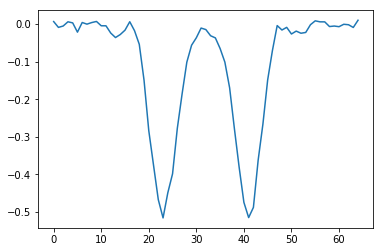

In [31]:
plt.plot(w[0])

In [32]:
def Utail(x):
    if(abs(x)<1):
        return 0
    return 4*0.5*(1.0/x**12-1.0/x**6)

Text(0.5, 0, 'x($\\sigma$)')

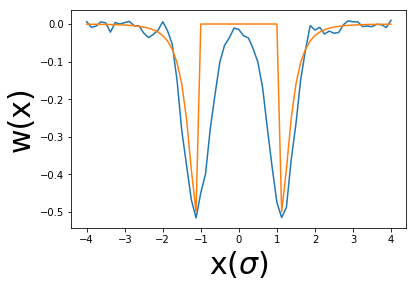

In [33]:
x = np.linspace(-LLw,LLw,Lw)*dx
for j in range (Nw):
    plt.plot(x,w[j],label="w"+str(j))
#plt.title("w")
tail = np.zeros(len(x))
for i in range(len(x)):
    tail[i]=Utail(x[i])
plt.plot(x,tail)
plt.ylabel("w(x)",size=30)
plt.xlabel("x($\sigma$)",size=30)
#plt.legend() 


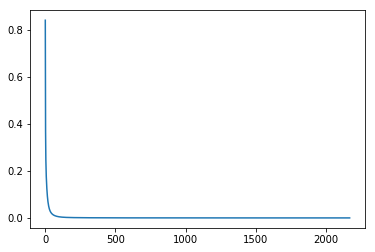

In [37]:
plt.plot(error_array)

In [35]:
save_data(w,error_array)